In this <a href="https://www.kaggle.com/c/house-prices-advanced-regression-techniques">kaggle</a> competition, we are given 79 explanatory variables that describe almost every aspect of a house. Our goal is to use these variables to predict the housing price.

The evaluation metric used for this competition is the Root Mean Squared Logarithmic Error (RMSLE):

\begin{equation}
    \epsilon = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (\log({p_i+1}) - (\log({a_i+1}))^2}
\end{equation}

Where:
$\epsilon$ is the RMSLE value, n is the number of predictions made, $p_i$ is the predicted value for the $i^{th}$ house and $a_i$ is the actual value of the $i^{th}$ house.

# Exploratory Data Analysis:

In [113]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [114]:
#Read in the training data
train = pd.read_csv('./Data/train.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


So we can see that there are a lot of variables and a lot of missing values in the data. Furthermore, there is both numerical data and categorical data. We will perform some data exploration to see if we can identify general trends within the data.

# Numerical Features:

## Correlation Matrix:

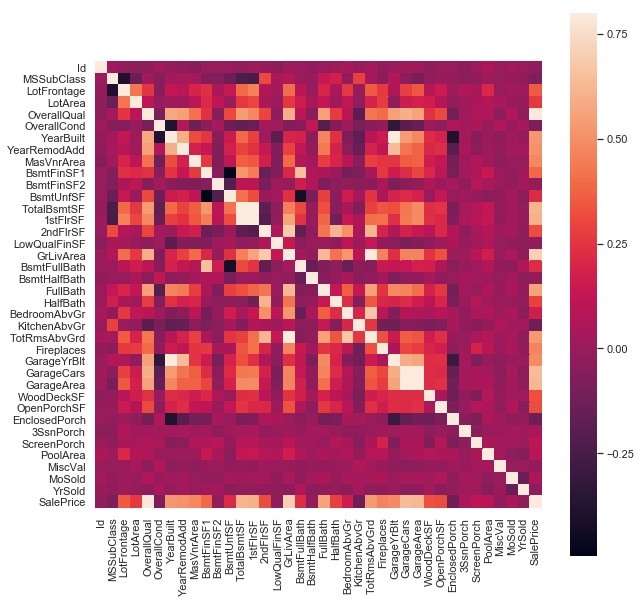

In [115]:
corr_matrix = train.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix, vmax=.8, square=True);

In [116]:
#Top five variables that correlate with SalePrice
corr_matrix['SalePrice'].sort_values(ascending=False)[:6]

SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
TotalBsmtSF    0.613581
Name: SalePrice, dtype: float64

Okay, so here we will only be looking at the top 5 correlated features (but in reality you should probably look at all the features). Lets take a closer look at these variables. Namely we want to know more about their statistics (mean, standard deviation, skewness, ...)

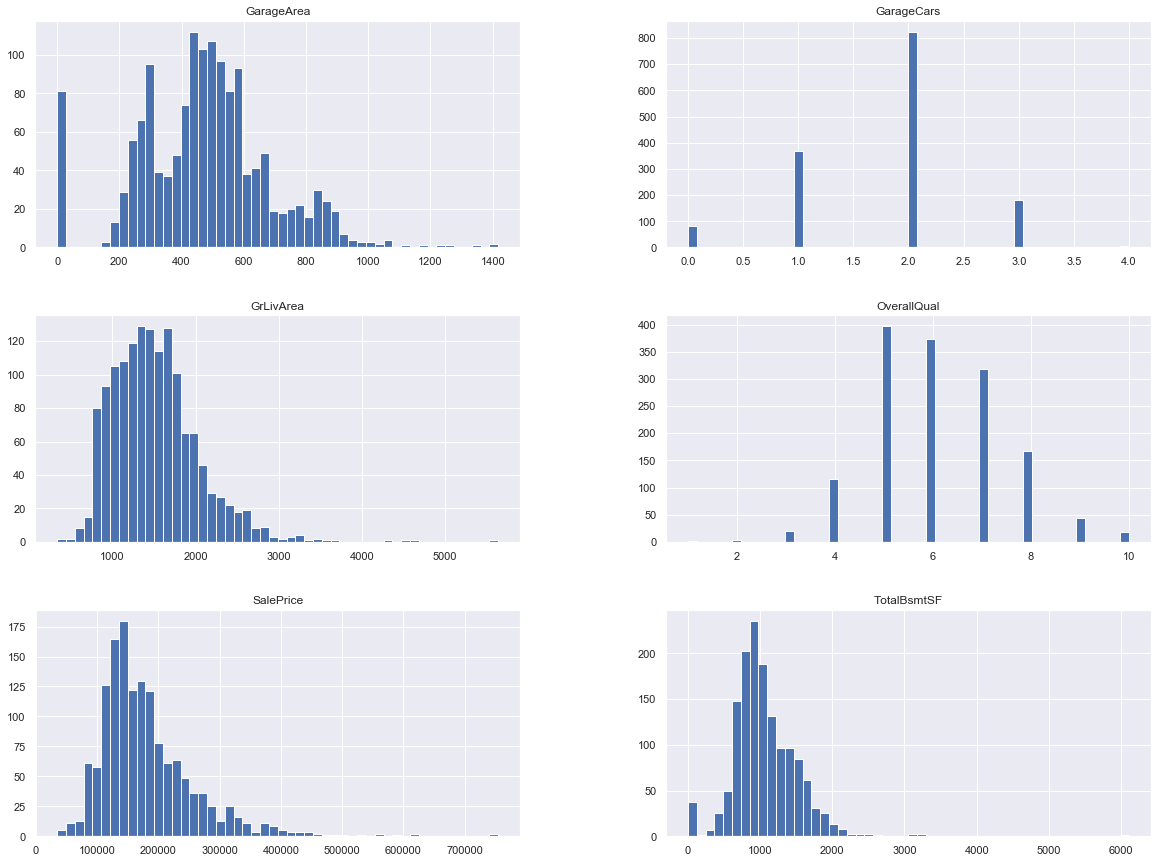

In [117]:
#Take a look at the histograms of our target variables
target_variables = ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', 'SalePrice']

train[target_variables].hist(bins=50, figsize=(20,15))
plt.show()

So of these features, some seem to be real numbers while others are categorized. Furthermore, a lot of them are right skewed. We may want to transform this data so it represents a more uniform distribution (take the log transform of the data).

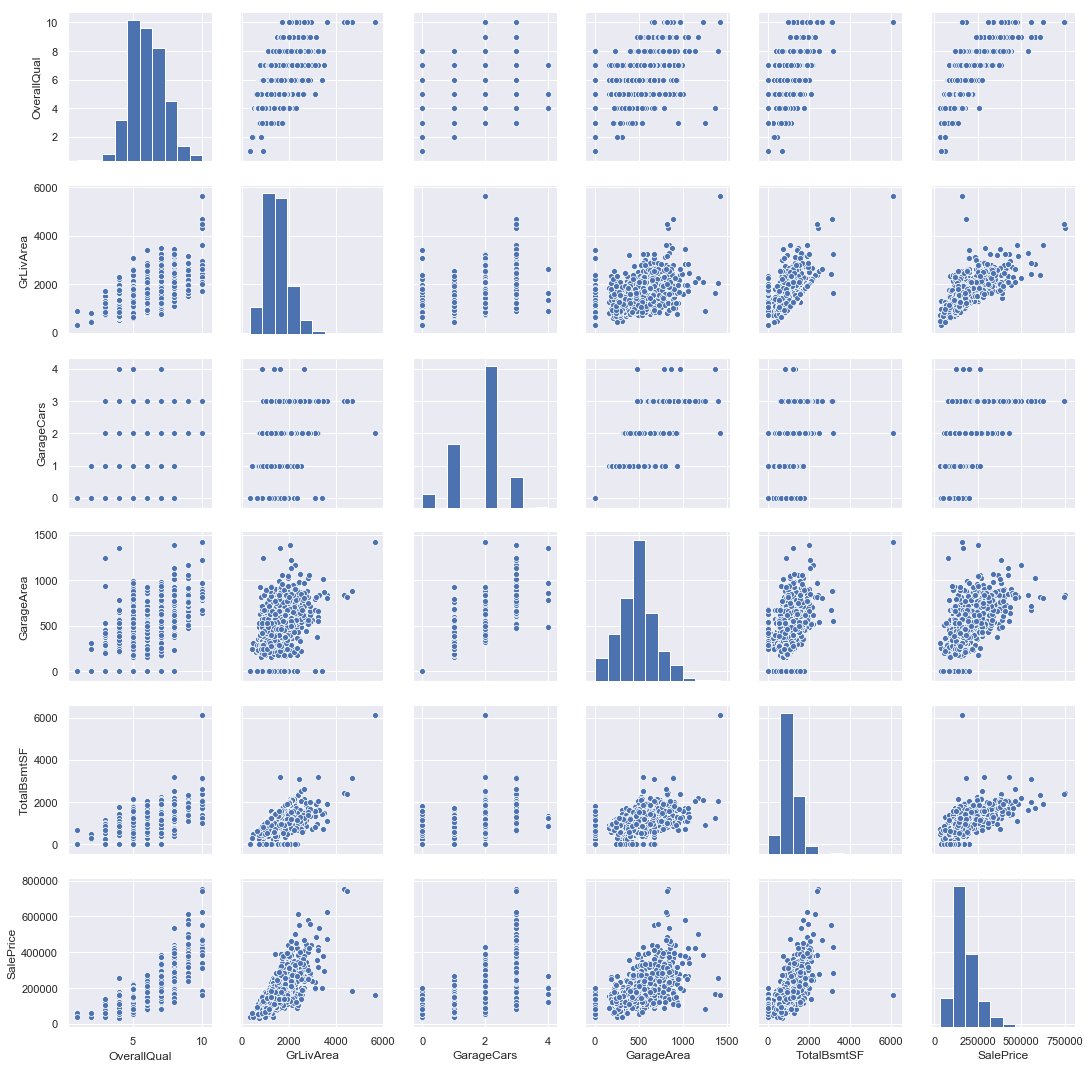

In [118]:
#Plot pairwise scatterplots
sns.set()
sns.pairplot(train[target_variables], height=2.5)
plt.show()

Looking at these scatter plots gives us a much better understanding of the data we are working with. Couple things we can point out from looking at these graphs are:
- GrLivArea, GarageArea and TotalBsmtSF seem to have a lot of values which are 0. This could simply be because the house is missing these things.
- The graph between TotalBsmtSF and GrLivArea seem to have this strange 45 degree line. This tells us that in general, houses have equal square footage in the ground floor and basement floor.

# Simple Baseline Model using FNN (only numeric features):

First, lets use a FNN network on all numerical features as a baseline to see how well we do without any feature engineering or data cleaning.

In [119]:
#Get list of text features
num_features = train.drop('SalePrice',axis=1).select_dtypes(include=["float64","int64"]).columns.values
num_features

array(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'], dtype=object)

In [120]:
#First see how many features have missing data.
train[num_features].isnull().sum().sort_values(ascending=False).head()

LotFrontage     259
GarageYrBlt      81
MasVnrArea        8
BsmtFinSF1        0
LowQualFinSF      0
dtype: int64

In [121]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()
X_train_num = imputer.fit_transform(train[num_features])
X_train_num = scaler.fit_transform(X_train_num)
X_train_num.shape

(1460, 37)

In [122]:
from tensorflow.python.keras.layers import Dense, Dropout
from tensorflow.python.keras.models import Sequential

model = Sequential()
model.add(Dense(256, input_dim=37, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate = 0.1))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_logarithmic_error', metrics=['mean_squared_logarithmic_error'])

In [123]:
model.fit(X_train_num, train['SalePrice'], validation_split=0.25, epochs=500, batch_size=256)

Train on 1095 samples, validate on 365 samples
Epoch 1/500
1095/1095 [==============================] - 0s 360us/sample - loss: 139.5883 - mean_squared_logarithmic_error: 139.5883 - val_loss: 129.6266 - val_mean_squared_logarithmic_error: 129.6266
Epoch 2/500
1095/1095 [==============================] - 0s 20us/sample - loss: 123.9658 - mean_squared_logarithmic_error: 123.9658 - val_loss: 115.8470 - val_mean_squared_logarithmic_error: 115.8470
Epoch 3/500
1095/1095 [==============================] - 0s 28us/sample - loss: 110.5599 - mean_squared_logarithmic_error: 110.5599 - val_loss: 103.5879 - val_mean_squared_logarithmic_error: 103.5879
Epoch 4/500
1095/1095 [==============================] - 0s 27us/sample - loss: 98.6697 - mean_squared_logarithmic_error: 98.6697 - val_loss: 92.8535 - val_mean_squared_logarithmic_error: 92.8535
Epoch 5/500
1095/1095 [==============================] - 0s 27us/sample - loss: 88.3125 - mean_squared_logarithmic_error: 88.3125 - val_loss: 83.6103 - val_

1095/1095 [==============================] - 0s 23us/sample - loss: 12.7261 - mean_squared_logarithmic_error: 12.7261 - val_loss: 13.7762 - val_mean_squared_logarithmic_error: 13.7762
Epoch 43/500
1095/1095 [==============================] - 0s 21us/sample - loss: 12.3189 - mean_squared_logarithmic_error: 12.3189 - val_loss: 13.3486 - val_mean_squared_logarithmic_error: 13.3486
Epoch 44/500
1095/1095 [==============================] - 0s 19us/sample - loss: 11.9134 - mean_squared_logarithmic_error: 11.9134 - val_loss: 12.9376 - val_mean_squared_logarithmic_error: 12.9376
Epoch 45/500
1095/1095 [==============================] - 0s 20us/sample - loss: 11.5220 - mean_squared_logarithmic_error: 11.5220 - val_loss: 12.5436 - val_mean_squared_logarithmic_error: 12.5436
Epoch 46/500
1095/1095 [==============================] - 0s 21us/sample - loss: 11.1473 - mean_squared_logarithmic_error: 11.1473 - val_loss: 12.1662 - val_mean_squared_logarithmic_error: 12.1662
Epoch 47/500
1095/1095 [====

1095/1095 [==============================] - 0s 22us/sample - loss: 3.7678 - mean_squared_logarithmic_error: 3.7678 - val_loss: 4.5112 - val_mean_squared_logarithmic_error: 4.5112
Epoch 85/500
1095/1095 [==============================] - 0s 20us/sample - loss: 3.6701 - mean_squared_logarithmic_error: 3.6701 - val_loss: 4.4088 - val_mean_squared_logarithmic_error: 4.4088
Epoch 86/500
1095/1095 [==============================] - 0s 20us/sample - loss: 3.5853 - mean_squared_logarithmic_error: 3.5853 - val_loss: 4.3095 - val_mean_squared_logarithmic_error: 4.3095
Epoch 87/500
1095/1095 [==============================] - 0s 20us/sample - loss: 3.4881 - mean_squared_logarithmic_error: 3.4881 - val_loss: 4.2128 - val_mean_squared_logarithmic_error: 4.2128
Epoch 88/500
1095/1095 [==============================] - 0s 21us/sample - loss: 3.4115 - mean_squared_logarithmic_error: 3.4115 - val_loss: 4.1187 - val_mean_squared_logarithmic_error: 4.1187
Epoch 89/500
1095/1095 [========================

1095/1095 [==============================] - 0s 20us/sample - loss: 1.3890 - mean_squared_logarithmic_error: 1.3890 - val_loss: 1.8799 - val_mean_squared_logarithmic_error: 1.8799
Epoch 127/500
1095/1095 [==============================] - 0s 20us/sample - loss: 1.3669 - mean_squared_logarithmic_error: 1.3669 - val_loss: 1.8449 - val_mean_squared_logarithmic_error: 1.8449
Epoch 128/500
1095/1095 [==============================] - 0s 31us/sample - loss: 1.3330 - mean_squared_logarithmic_error: 1.3330 - val_loss: 1.8108 - val_mean_squared_logarithmic_error: 1.8108
Epoch 129/500
1095/1095 [==============================] - 0s 21us/sample - loss: 1.3079 - mean_squared_logarithmic_error: 1.3079 - val_loss: 1.7775 - val_mean_squared_logarithmic_error: 1.7775
Epoch 130/500
1095/1095 [==============================] - 0s 21us/sample - loss: 1.2763 - mean_squared_logarithmic_error: 1.2763 - val_loss: 1.7450 - val_mean_squared_logarithmic_error: 1.7450
Epoch 131/500
1095/1095 [===================

1095/1095 [==============================] - 0s 22us/sample - loss: 0.5960 - mean_squared_logarithmic_error: 0.5960 - val_loss: 0.9229 - val_mean_squared_logarithmic_error: 0.9229
Epoch 169/500
1095/1095 [==============================] - 0s 20us/sample - loss: 0.5916 - mean_squared_logarithmic_error: 0.5916 - val_loss: 0.9091 - val_mean_squared_logarithmic_error: 0.9091
Epoch 170/500
1095/1095 [==============================] - 0s 21us/sample - loss: 0.5746 - mean_squared_logarithmic_error: 0.5746 - val_loss: 0.8956 - val_mean_squared_logarithmic_error: 0.8956
Epoch 171/500
1095/1095 [==============================] - 0s 20us/sample - loss: 0.5663 - mean_squared_logarithmic_error: 0.5663 - val_loss: 0.8823 - val_mean_squared_logarithmic_error: 0.8823
Epoch 172/500
1095/1095 [==============================] - 0s 21us/sample - loss: 0.5557 - mean_squared_logarithmic_error: 0.5557 - val_loss: 0.8694 - val_mean_squared_logarithmic_error: 0.8694
Epoch 173/500
1095/1095 [===================

1095/1095 [==============================] - 0s 21us/sample - loss: 0.3084 - mean_squared_logarithmic_error: 0.3084 - val_loss: 0.5314 - val_mean_squared_logarithmic_error: 0.5314
Epoch 211/500
1095/1095 [==============================] - 0s 21us/sample - loss: 0.3073 - mean_squared_logarithmic_error: 0.3073 - val_loss: 0.5255 - val_mean_squared_logarithmic_error: 0.5255
Epoch 212/500
1095/1095 [==============================] - 0s 20us/sample - loss: 0.3030 - mean_squared_logarithmic_error: 0.3030 - val_loss: 0.5198 - val_mean_squared_logarithmic_error: 0.5198
Epoch 213/500
1095/1095 [==============================] - 0s 21us/sample - loss: 0.2959 - mean_squared_logarithmic_error: 0.2959 - val_loss: 0.5141 - val_mean_squared_logarithmic_error: 0.5141
Epoch 214/500
1095/1095 [==============================] - 0s 23us/sample - loss: 0.2932 - mean_squared_logarithmic_error: 0.2932 - val_loss: 0.5087 - val_mean_squared_logarithmic_error: 0.5087
Epoch 215/500
1095/1095 [===================

1095/1095 [==============================] - 0s 20us/sample - loss: 0.2039 - mean_squared_logarithmic_error: 0.2039 - val_loss: 0.3579 - val_mean_squared_logarithmic_error: 0.3579
Epoch 253/500
1095/1095 [==============================] - 0s 22us/sample - loss: 0.1960 - mean_squared_logarithmic_error: 0.1960 - val_loss: 0.3552 - val_mean_squared_logarithmic_error: 0.3552
Epoch 254/500
1095/1095 [==============================] - 0s 20us/sample - loss: 0.1966 - mean_squared_logarithmic_error: 0.1966 - val_loss: 0.3524 - val_mean_squared_logarithmic_error: 0.3524
Epoch 255/500
1095/1095 [==============================] - 0s 19us/sample - loss: 0.1940 - mean_squared_logarithmic_error: 0.1940 - val_loss: 0.3497 - val_mean_squared_logarithmic_error: 0.3497
Epoch 256/500
1095/1095 [==============================] - 0s 20us/sample - loss: 0.1940 - mean_squared_logarithmic_error: 0.1940 - val_loss: 0.3471 - val_mean_squared_logarithmic_error: 0.3471
Epoch 257/500
1095/1095 [===================

1095/1095 [==============================] - 0s 20us/sample - loss: 0.1524 - mean_squared_logarithmic_error: 0.1524 - val_loss: 0.2709 - val_mean_squared_logarithmic_error: 0.2709
Epoch 295/500
1095/1095 [==============================] - 0s 21us/sample - loss: 0.1511 - mean_squared_logarithmic_error: 0.1511 - val_loss: 0.2694 - val_mean_squared_logarithmic_error: 0.2694
Epoch 296/500
1095/1095 [==============================] - 0s 20us/sample - loss: 0.1477 - mean_squared_logarithmic_error: 0.1477 - val_loss: 0.2679 - val_mean_squared_logarithmic_error: 0.2679
Epoch 297/500
1095/1095 [==============================] - 0s 22us/sample - loss: 0.1503 - mean_squared_logarithmic_error: 0.1503 - val_loss: 0.2665 - val_mean_squared_logarithmic_error: 0.2665
Epoch 298/500
1095/1095 [==============================] - 0s 26us/sample - loss: 0.1474 - mean_squared_logarithmic_error: 0.1474 - val_loss: 0.2650 - val_mean_squared_logarithmic_error: 0.2650
Epoch 299/500
1095/1095 [===================

1095/1095 [==============================] - 0s 21us/sample - loss: 0.1282 - mean_squared_logarithmic_error: 0.1282 - val_loss: 0.2207 - val_mean_squared_logarithmic_error: 0.2207
Epoch 337/500
1095/1095 [==============================] - 0s 21us/sample - loss: 0.1248 - mean_squared_logarithmic_error: 0.1248 - val_loss: 0.2197 - val_mean_squared_logarithmic_error: 0.2197
Epoch 338/500
1095/1095 [==============================] - 0s 21us/sample - loss: 0.1240 - mean_squared_logarithmic_error: 0.1240 - val_loss: 0.2188 - val_mean_squared_logarithmic_error: 0.2188
Epoch 339/500
1095/1095 [==============================] - 0s 20us/sample - loss: 0.1234 - mean_squared_logarithmic_error: 0.1234 - val_loss: 0.2179 - val_mean_squared_logarithmic_error: 0.2179
Epoch 340/500
1095/1095 [==============================] - 0s 20us/sample - loss: 0.1233 - mean_squared_logarithmic_error: 0.1233 - val_loss: 0.2170 - val_mean_squared_logarithmic_error: 0.2170
Epoch 341/500
1095/1095 [===================

1095/1095 [==============================] - 0s 24us/sample - loss: 0.1043 - mean_squared_logarithmic_error: 0.1043 - val_loss: 0.1876 - val_mean_squared_logarithmic_error: 0.1876
Epoch 379/500
1095/1095 [==============================] - 0s 22us/sample - loss: 0.1057 - mean_squared_logarithmic_error: 0.1057 - val_loss: 0.1871 - val_mean_squared_logarithmic_error: 0.1871
Epoch 380/500
1095/1095 [==============================] - 0s 20us/sample - loss: 0.1061 - mean_squared_logarithmic_error: 0.1061 - val_loss: 0.1865 - val_mean_squared_logarithmic_error: 0.1865
Epoch 381/500
1095/1095 [==============================] - 0s 24us/sample - loss: 0.1050 - mean_squared_logarithmic_error: 0.1050 - val_loss: 0.1859 - val_mean_squared_logarithmic_error: 0.1859
Epoch 382/500
1095/1095 [==============================] - 0s 21us/sample - loss: 0.1053 - mean_squared_logarithmic_error: 0.1053 - val_loss: 0.1853 - val_mean_squared_logarithmic_error: 0.1853
Epoch 383/500
1095/1095 [===================

1095/1095 [==============================] - 0s 23us/sample - loss: 0.0946 - mean_squared_logarithmic_error: 0.0946 - val_loss: 0.1647 - val_mean_squared_logarithmic_error: 0.1647
Epoch 421/500
1095/1095 [==============================] - 0s 21us/sample - loss: 0.0926 - mean_squared_logarithmic_error: 0.0926 - val_loss: 0.1642 - val_mean_squared_logarithmic_error: 0.1642
Epoch 422/500
1095/1095 [==============================] - 0s 23us/sample - loss: 0.0934 - mean_squared_logarithmic_error: 0.0934 - val_loss: 0.1638 - val_mean_squared_logarithmic_error: 0.1638
Epoch 423/500
1095/1095 [==============================] - 0s 25us/sample - loss: 0.0903 - mean_squared_logarithmic_error: 0.0903 - val_loss: 0.1634 - val_mean_squared_logarithmic_error: 0.1634
Epoch 424/500
1095/1095 [==============================] - 0s 22us/sample - loss: 0.0941 - mean_squared_logarithmic_error: 0.0941 - val_loss: 0.1630 - val_mean_squared_logarithmic_error: 0.1630
Epoch 425/500
1095/1095 [===================

1095/1095 [==============================] - 0s 19us/sample - loss: 0.0835 - mean_squared_logarithmic_error: 0.0835 - val_loss: 0.1472 - val_mean_squared_logarithmic_error: 0.1472
Epoch 463/500
1095/1095 [==============================] - 0s 22us/sample - loss: 0.0834 - mean_squared_logarithmic_error: 0.0834 - val_loss: 0.1469 - val_mean_squared_logarithmic_error: 0.1469
Epoch 464/500
1095/1095 [==============================] - 0s 20us/sample - loss: 0.0816 - mean_squared_logarithmic_error: 0.0816 - val_loss: 0.1465 - val_mean_squared_logarithmic_error: 0.1465
Epoch 465/500
1095/1095 [==============================] - 0s 19us/sample - loss: 0.0827 - mean_squared_logarithmic_error: 0.0827 - val_loss: 0.1461 - val_mean_squared_logarithmic_error: 0.1461
Epoch 466/500
1095/1095 [==============================] - 0s 20us/sample - loss: 0.0819 - mean_squared_logarithmic_error: 0.0819 - val_loss: 0.1458 - val_mean_squared_logarithmic_error: 0.1458
Epoch 467/500
1095/1095 [===================

In [124]:
test = pd.read_csv('./Data/test.csv')

X_test_num = imputer.fit_transform(test[num_features])
X_test_num = scaler.fit_transform(X_test_num)
X_test_num.shape

predictions = model.predict(X_test_num)
submissions = pd.DataFrame({'Id': test.Id.values, 'SalePrice':predictions[:,0]})
submissions.to_csv("./submissions.csv",index=False)

So with our baseline model, we were able to get a validation loss of about 0.1172. This score will be our baseline. Lets see how much better we can do if we clean up our data a little bit and perform some feature engineering.

# NN Regressor with Text Categorical Features:

Lets do some feature engineering on these text categorical features so that we can use them in our model.

In [125]:
text_cat_features = train.select_dtypes(include='object').columns.values
train[text_cat_features].head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [126]:
print("Text Categorical Features: \n{}".format(text_cat_features))

Text Categorical Features: 
['MSZoning' 'Street' 'Alley' 'LotShape' 'LandContour' 'Utilities'
 'LotConfig' 'LandSlope' 'Neighborhood' 'Condition1' 'Condition2'
 'BldgType' 'HouseStyle' 'RoofStyle' 'RoofMatl' 'Exterior1st'
 'Exterior2nd' 'MasVnrType' 'ExterQual' 'ExterCond' 'Foundation'
 'BsmtQual' 'BsmtCond' 'BsmtExposure' 'BsmtFinType1' 'BsmtFinType2'
 'Heating' 'HeatingQC' 'CentralAir' 'Electrical' 'KitchenQual'
 'Functional' 'FireplaceQu' 'GarageType' 'GarageFinish' 'GarageQual'
 'GarageCond' 'PavedDrive' 'PoolQC' 'Fence' 'MiscFeature' 'SaleType'
 'SaleCondition']


Okay, so some features that I think would correlate well with SalePrice (based on what I personally would look for in buying a new house).

- SaleCondition
- Neighborhood
- Condition1
- Condition2
- ExterQual
- ExterCond
- GarageQual
- GarageCond
- MSZoning

In [127]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
imputer = SimpleImputer(strategy='most_frequent')
X_train_text_cat = imputer.fit_transform(train[text_cat_features])
X_train_text_cat = encoder.fit_transform(X_train_text_cat)
X_train_text_cat.shape

(1460, 252)

In [128]:
X_train_text_num = np.concatenate((X_train_num,X_train_text_cat.toarray()),axis=1)
X_train_text_num.shape

(1460, 289)

In [129]:
model = Sequential()
model.add(Dense(256, input_dim=289, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_logarithmic_error', metrics=['mean_squared_logarithmic_error'])

model.fit(X_train_text_num, train['SalePrice'], epochs=500, validation_split=0.25, batch_size=256, verbose=2)

Train on 1095 samples, validate on 365 samples
Epoch 1/500
 - 0s - loss: 135.2313 - mean_squared_logarithmic_error: 135.2313 - val_loss: 119.3467 - val_mean_squared_logarithmic_error: 119.3467
Epoch 2/500
 - 0s - loss: 111.7961 - mean_squared_logarithmic_error: 111.7961 - val_loss: 98.7050 - val_mean_squared_logarithmic_error: 98.7050
Epoch 3/500
 - 0s - loss: 92.3908 - mean_squared_logarithmic_error: 92.3908 - val_loss: 82.0405 - val_mean_squared_logarithmic_error: 82.0405
Epoch 4/500
 - 0s - loss: 77.0938 - mean_squared_logarithmic_error: 77.0938 - val_loss: 69.3895 - val_mean_squared_logarithmic_error: 69.3895
Epoch 5/500
 - 0s - loss: 65.4871 - mean_squared_logarithmic_error: 65.4871 - val_loss: 59.6750 - val_mean_squared_logarithmic_error: 59.6750
Epoch 6/500
 - 0s - loss: 56.6105 - mean_squared_logarithmic_error: 56.6105 - val_loss: 52.0516 - val_mean_squared_logarithmic_error: 52.0516
Epoch 7/500
 - 0s - loss: 49.4963 - mean_squared_logarithmic_error: 49.4963 - val_loss: 45.9436

Epoch 59/500
 - 0s - loss: 1.7575 - mean_squared_logarithmic_error: 1.7575 - val_loss: 1.7637 - val_mean_squared_logarithmic_error: 1.7637
Epoch 60/500
 - 0s - loss: 1.6500 - mean_squared_logarithmic_error: 1.6500 - val_loss: 1.6830 - val_mean_squared_logarithmic_error: 1.6830
Epoch 61/500
 - 0s - loss: 1.5948 - mean_squared_logarithmic_error: 1.5948 - val_loss: 1.6063 - val_mean_squared_logarithmic_error: 1.6063
Epoch 62/500
 - 0s - loss: 1.5152 - mean_squared_logarithmic_error: 1.5152 - val_loss: 1.5335 - val_mean_squared_logarithmic_error: 1.5335
Epoch 63/500
 - 0s - loss: 1.4474 - mean_squared_logarithmic_error: 1.4474 - val_loss: 1.4642 - val_mean_squared_logarithmic_error: 1.4642
Epoch 64/500
 - 0s - loss: 1.3922 - mean_squared_logarithmic_error: 1.3922 - val_loss: 1.3985 - val_mean_squared_logarithmic_error: 1.3985
Epoch 65/500
 - 0s - loss: 1.3135 - mean_squared_logarithmic_error: 1.3135 - val_loss: 1.3357 - val_mean_squared_logarithmic_error: 1.3357
Epoch 66/500
 - 0s - loss: 

Epoch 118/500
 - 0s - loss: 0.1534 - mean_squared_logarithmic_error: 0.1534 - val_loss: 0.1512 - val_mean_squared_logarithmic_error: 0.1512
Epoch 119/500
 - 0s - loss: 0.1486 - mean_squared_logarithmic_error: 0.1486 - val_loss: 0.1465 - val_mean_squared_logarithmic_error: 0.1465
Epoch 120/500
 - 0s - loss: 0.1489 - mean_squared_logarithmic_error: 0.1489 - val_loss: 0.1421 - val_mean_squared_logarithmic_error: 0.1421
Epoch 121/500
 - 0s - loss: 0.1418 - mean_squared_logarithmic_error: 0.1418 - val_loss: 0.1380 - val_mean_squared_logarithmic_error: 0.1380
Epoch 122/500
 - 0s - loss: 0.1411 - mean_squared_logarithmic_error: 0.1411 - val_loss: 0.1341 - val_mean_squared_logarithmic_error: 0.1341
Epoch 123/500
 - 0s - loss: 0.1369 - mean_squared_logarithmic_error: 0.1369 - val_loss: 0.1303 - val_mean_squared_logarithmic_error: 0.1303
Epoch 124/500
 - 0s - loss: 0.1300 - mean_squared_logarithmic_error: 0.1300 - val_loss: 0.1267 - val_mean_squared_logarithmic_error: 0.1267
Epoch 125/500
 - 0s 

Epoch 177/500
 - 0s - loss: 0.0671 - mean_squared_logarithmic_error: 0.0671 - val_loss: 0.0549 - val_mean_squared_logarithmic_error: 0.0549
Epoch 178/500
 - 0s - loss: 0.0660 - mean_squared_logarithmic_error: 0.0660 - val_loss: 0.0544 - val_mean_squared_logarithmic_error: 0.0544
Epoch 179/500
 - 0s - loss: 0.0643 - mean_squared_logarithmic_error: 0.0643 - val_loss: 0.0539 - val_mean_squared_logarithmic_error: 0.0539
Epoch 180/500
 - 0s - loss: 0.0683 - mean_squared_logarithmic_error: 0.0683 - val_loss: 0.0534 - val_mean_squared_logarithmic_error: 0.0534
Epoch 181/500
 - 0s - loss: 0.0645 - mean_squared_logarithmic_error: 0.0645 - val_loss: 0.0529 - val_mean_squared_logarithmic_error: 0.0529
Epoch 182/500
 - 0s - loss: 0.0668 - mean_squared_logarithmic_error: 0.0668 - val_loss: 0.0524 - val_mean_squared_logarithmic_error: 0.0524
Epoch 183/500
 - 0s - loss: 0.0644 - mean_squared_logarithmic_error: 0.0644 - val_loss: 0.0519 - val_mean_squared_logarithmic_error: 0.0519
Epoch 184/500
 - 0s 

Epoch 236/500
 - 0s - loss: 0.0459 - mean_squared_logarithmic_error: 0.0459 - val_loss: 0.0358 - val_mean_squared_logarithmic_error: 0.0358
Epoch 237/500
 - 0s - loss: 0.0438 - mean_squared_logarithmic_error: 0.0438 - val_loss: 0.0356 - val_mean_squared_logarithmic_error: 0.0356
Epoch 238/500
 - 0s - loss: 0.0447 - mean_squared_logarithmic_error: 0.0447 - val_loss: 0.0354 - val_mean_squared_logarithmic_error: 0.0354
Epoch 239/500
 - 0s - loss: 0.0430 - mean_squared_logarithmic_error: 0.0430 - val_loss: 0.0352 - val_mean_squared_logarithmic_error: 0.0352
Epoch 240/500
 - 0s - loss: 0.0453 - mean_squared_logarithmic_error: 0.0453 - val_loss: 0.0351 - val_mean_squared_logarithmic_error: 0.0351
Epoch 241/500
 - 0s - loss: 0.0444 - mean_squared_logarithmic_error: 0.0444 - val_loss: 0.0349 - val_mean_squared_logarithmic_error: 0.0349
Epoch 242/500
 - 0s - loss: 0.0446 - mean_squared_logarithmic_error: 0.0446 - val_loss: 0.0347 - val_mean_squared_logarithmic_error: 0.0347
Epoch 243/500
 - 0s 

Epoch 295/500
 - 0s - loss: 0.0365 - mean_squared_logarithmic_error: 0.0365 - val_loss: 0.0302 - val_mean_squared_logarithmic_error: 0.0302
Epoch 296/500
 - 0s - loss: 0.0362 - mean_squared_logarithmic_error: 0.0362 - val_loss: 0.0302 - val_mean_squared_logarithmic_error: 0.0302
Epoch 297/500
 - 0s - loss: 0.0365 - mean_squared_logarithmic_error: 0.0365 - val_loss: 0.0302 - val_mean_squared_logarithmic_error: 0.0302
Epoch 298/500
 - 0s - loss: 0.0366 - mean_squared_logarithmic_error: 0.0366 - val_loss: 0.0301 - val_mean_squared_logarithmic_error: 0.0301
Epoch 299/500
 - 0s - loss: 0.0358 - mean_squared_logarithmic_error: 0.0358 - val_loss: 0.0301 - val_mean_squared_logarithmic_error: 0.0301
Epoch 300/500
 - 0s - loss: 0.0373 - mean_squared_logarithmic_error: 0.0373 - val_loss: 0.0301 - val_mean_squared_logarithmic_error: 0.0301
Epoch 301/500
 - 0s - loss: 0.0363 - mean_squared_logarithmic_error: 0.0363 - val_loss: 0.0300 - val_mean_squared_logarithmic_error: 0.0300
Epoch 302/500
 - 0s 

Epoch 354/500
 - 0s - loss: 0.0333 - mean_squared_logarithmic_error: 0.0333 - val_loss: 0.0287 - val_mean_squared_logarithmic_error: 0.0287
Epoch 355/500
 - 0s - loss: 0.0335 - mean_squared_logarithmic_error: 0.0335 - val_loss: 0.0287 - val_mean_squared_logarithmic_error: 0.0287
Epoch 356/500
 - 0s - loss: 0.0336 - mean_squared_logarithmic_error: 0.0336 - val_loss: 0.0286 - val_mean_squared_logarithmic_error: 0.0286
Epoch 357/500
 - 0s - loss: 0.0310 - mean_squared_logarithmic_error: 0.0310 - val_loss: 0.0286 - val_mean_squared_logarithmic_error: 0.0286
Epoch 358/500
 - 0s - loss: 0.0327 - mean_squared_logarithmic_error: 0.0327 - val_loss: 0.0286 - val_mean_squared_logarithmic_error: 0.0286
Epoch 359/500
 - 0s - loss: 0.0317 - mean_squared_logarithmic_error: 0.0317 - val_loss: 0.0285 - val_mean_squared_logarithmic_error: 0.0285
Epoch 360/500
 - 0s - loss: 0.0348 - mean_squared_logarithmic_error: 0.0348 - val_loss: 0.0285 - val_mean_squared_logarithmic_error: 0.0285
Epoch 361/500
 - 0s 

Epoch 413/500
 - 0s - loss: 0.0310 - mean_squared_logarithmic_error: 0.0310 - val_loss: 0.0274 - val_mean_squared_logarithmic_error: 0.0274
Epoch 414/500
 - 0s - loss: 0.0312 - mean_squared_logarithmic_error: 0.0312 - val_loss: 0.0274 - val_mean_squared_logarithmic_error: 0.0274
Epoch 415/500
 - 0s - loss: 0.0318 - mean_squared_logarithmic_error: 0.0318 - val_loss: 0.0274 - val_mean_squared_logarithmic_error: 0.0274
Epoch 416/500
 - 0s - loss: 0.0303 - mean_squared_logarithmic_error: 0.0303 - val_loss: 0.0274 - val_mean_squared_logarithmic_error: 0.0274
Epoch 417/500
 - 0s - loss: 0.0318 - mean_squared_logarithmic_error: 0.0318 - val_loss: 0.0273 - val_mean_squared_logarithmic_error: 0.0273
Epoch 418/500
 - 0s - loss: 0.0331 - mean_squared_logarithmic_error: 0.0331 - val_loss: 0.0273 - val_mean_squared_logarithmic_error: 0.0273
Epoch 419/500
 - 0s - loss: 0.0309 - mean_squared_logarithmic_error: 0.0309 - val_loss: 0.0272 - val_mean_squared_logarithmic_error: 0.0272
Epoch 420/500
 - 0s 

Epoch 472/500
 - 0s - loss: 0.0284 - mean_squared_logarithmic_error: 0.0284 - val_loss: 0.0260 - val_mean_squared_logarithmic_error: 0.0260
Epoch 473/500
 - 0s - loss: 0.0298 - mean_squared_logarithmic_error: 0.0298 - val_loss: 0.0260 - val_mean_squared_logarithmic_error: 0.0260
Epoch 474/500
 - 0s - loss: 0.0300 - mean_squared_logarithmic_error: 0.0300 - val_loss: 0.0259 - val_mean_squared_logarithmic_error: 0.0259
Epoch 475/500
 - 0s - loss: 0.0280 - mean_squared_logarithmic_error: 0.0280 - val_loss: 0.0259 - val_mean_squared_logarithmic_error: 0.0259
Epoch 476/500
 - 0s - loss: 0.0279 - mean_squared_logarithmic_error: 0.0279 - val_loss: 0.0259 - val_mean_squared_logarithmic_error: 0.0259
Epoch 477/500
 - 0s - loss: 0.0298 - mean_squared_logarithmic_error: 0.0298 - val_loss: 0.0259 - val_mean_squared_logarithmic_error: 0.0259
Epoch 478/500
 - 0s - loss: 0.0284 - mean_squared_logarithmic_error: 0.0284 - val_loss: 0.0259 - val_mean_squared_logarithmic_error: 0.0259
Epoch 479/500
 - 0s 

In [130]:
model.fit(X_train_text_num, train['SalePrice'], epochs=500, batch_size=256, verbose=0)

In [131]:
test = pd.read_csv('./Data/test.csv')

X_test_text_cat = imputer.transform(test[text_cat_features])
X_test_text_cat = encoder.transform(X_test_text_cat)

X_test_text_num = np.concatenate((X_test_num,X_test_text_cat.toarray()),axis=1)

predictions = model.predict(X_test_text_num)
submissions = pd.DataFrame({'Id': test.Id.values, 'SalePrice':predictions[:,0]})
submissions.to_csv("./submissions.csv",index=False)

So after including the other text features, our accuracy has gone up significantly. From 0.126 error to 0.0196, this is a really big improvement and shows us that a lot of useful information was inside of the text features.

# Simple Linear Regressors

Now we will test linear regressor models and see how well they do. We will be trying:
- Ridge Regression (Regularized Linear Regression with L1 loss)
- Elastic Net Regression (Regularized Linear Regression that uses a mixture of L1 & L2 loss)

In [132]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

ridge = Ridge()
scores = cross_val_score(ridge, X_train_text_num, train['SalePrice'], cv=5, scoring='neg_mean_squared_log_error')
-scores.mean()

0.027797339390924415

In [133]:
from sklearn.linear_model import ElasticNet

elastic = ElasticNet()
scores = cross_val_score(elastic, X_train_text_num, train['SalePrice'], cv=5, scoring='neg_mean_squared_log_error')
-scores.mean()

0.0226917925286332

Okay, so ElasticNet performs slightly better than Ridge regression. Lets try to use both of these estimators together in an ensemble method and see how we do!

# Ensemble Learning

In this section, we are going to pair up our NN with a basic linear regressor to perform some ensemble learning. Most of the time an ensemble method performs better than a singular method, so lets test it out!

In [138]:
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train_text_num, train['SalePrice'],
                                                    test_size=0.25, random_state=42)
ridge = Ridge()
elastic = ElasticNet()
model.fit(X_train, y_train,epochs=500,verbose=0)
ridge.fit(X_train,y_train)
elastic.fit(X_train,y_train)

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [143]:
predictions_NN = model.predict(X_test).reshape(-1)
predictions_ridge = ridge.predict(X_test)
predictions_elastic = elastic.predict(X_test)

predictions = 0.5*predictions_NN + 0.25*predictions_ridge + 0.25*predictions_elastic

score = mean_squared_log_error(predictions, y_test)
score

0.0055173098938672924

Okay, so our ensemble model achieves an even lower accuracy! Thats great, lets use this model to predict the house prices and make our submission.

In [141]:
ridge = Ridge()
elastic = ElasticNet()
ridge.fit(X_train_text_num, train['SalePrice'])
model.fit(X_train_text_num, train['SalePrice'], epochs=500, verbose=0)
elastic.fit(X_train_text_num, train['SalePrice'])

predictions_NN = model.predict(X_test_text_num).reshape(-1)
predictions_ridge = ridge.predict(X_test_text_num)
predictions_elastic = elastic.predict(X_test_text_num)

predictions = 0.5*predictions_NN + 0.25*predictions_ridge + 0.25*predictions_elastic

submissions = pd.DataFrame({'Id': test.Id.values, 'SalePrice':predictions})
submissions.to_csv("./submissions.csv",index=False)

We score a 0.13608 on the kaggle competition. Currently the top results are 0.11 - 0.10